<h1 style="text-align: center">Kaggle Titanic Dataset</h1>
<h3 style="text-align: center">Predicting passenger survival</h3>


In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import math as math
import re
import csv

TRAIN_DATA_FILE = "train.csv"
TEST_DATA_FILE = "test.csv"
DATA_OUTPUT_NAME = "answers.csv"
TRIALS_FILE = "trials.csv"
BEST_TRIALS_FILE = "best_trials.csv"
UNKNOWN_AGE_INSERT = 0

## Fetching and Organizing Data

#### Raw Passenger Data
Passenger Data is returned as a list of strings, in the order of the following:
*Passenger Id, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked*

#### Parsed Passenger Data
Passenger Data needs to be parsed and converted into numbers for the machine learning algorithms to take over. The following will be the parsing scheme. This will also be the order as well

1. **Passenger Id**: This will stay the same, nor will be converted into an int.
2. **Survived**: 0 for died, 1 for survived
3. **Pclass**: 1 for upper class, 2 for middle class, 3 for lower class
4. **Sex**: 0 for Male, 1 for Female
5. **Age**: Float from the string, if it is an empty string then going to default to age of 30 (arbitrary).
6. **SibSp**: Sibling/Spouse on board, staying the same.
7. **Parch**: # of Parent/Children on board, staying the same.
8. **Fare**: Convert to a float

### Fetching the Data Pandas

In [6]:
RawTrainData = pd.read_csv(TRAIN_DATA_FILE, index_col=None)
RawSubmissionData = pd.read_csv(TEST_DATA_FILE, index_col=None)
print(RawTrainData.head())
TOTAL_PASSENGERS_T = RawTrainData.shape[0]
TOTAL_PASSENGERS_S = RawSubmissionData.shape[0]

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


### Parsing the Data Functions

In [7]:
def ParseSurvived(survived: str) -> int:
    try:
        return int(float(survived))
    except Exception as ex:
        print(str(ex))
        return 0

def ParseAge(age: str) -> int:
    try:
        isAdult = int(age) >= 18
        if isAdult:
            Adult = 1
            Child = 0
        else:
            Adult = 0
            Child = 1

        return float(age) / 100, Adult, Child
    except ValueError:
        return UNKNOWN_AGE_INSERT / 100, 0, 0

def DetermineTitle(name: str) -> int:
    Mr = re.findall("Mr\.", name)
    Miss = re.findall("Miss\.", name)
    Mrs = re.findall("Mrs\.", name)

    if len(Mr) > 0:
        return 3
    elif len(Mrs) > 0:
        return 2
    elif len(Miss) > 0:
        return 1
    else:
        return 0
    
def ParseFare(fare, pclass):
    try:
        if fare == '':
            if pclass == 1:
                return 70 / 100
            elif pclass == 2:
                return 25 / 100
            else:
                return 7.25 / 100
        else:
            return float(fare)
    except ValueError:
        print("Parseing fare went wrong.")
        return 7.25 / 100
    except Exception as ex:
        print(f"ParseFare error: {ex}")
        return 7.25 / 100

def ParseCabin(cabin):
    for a in cabin:
        if a == 'A':
            return 6
        elif a == 'B':
            return 5
        elif a == 'C':
            return 4
        elif a == 'D':
            return 3
        elif a == 'E':
            return 2
        elif a == 'F':
            return 1
        
    return 0

def ParseEmbarked(embarked):
    if embarked == 'C':
        return 1
    elif embarked == 'Q':
        return 2
    elif embarked == 'S':
        return 3
    else:
        return 0
    
def IsMother(Title, Adult, Parch):
    return int((Title == 2 or Title == 0) and (Adult == 1) and (Parch >= 1))
    

def ParsePassengerData(passenger: list) -> list:
    """Takes passenger data and converts all the types to be usable for the machine learning. See the paragraph above for the information.
     

    Args:
        passenger (list): PassengerId, Survived (optional), Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

    Returns:
        list: PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare
    """
    try:
        # Passenger surviving wasn't added. Add a '0' for survivied (mirroring test data)
        if len(passenger) < 12:
            passenger.insert(1, '0')
        
        if len(passenger) < 12:
            print("List is less than 12 elements still.")
            print(f"Passenger: {passenger}")
            raise Exception(ValueError)
        
        PassengerId = float(passenger[0])
        Survived = float(ParseSurvived(passenger[1]))
        Pclass = float(passenger[2])
        #  Name is irrelevant (passenger[3])
        Sex = float(passenger[4] != 'female')
        Age, Adult, Child = ParseAge(passenger[5])
        SibSp = float(passenger[6])
        Parch = float(passenger[7])
        # Ticket is irrelevant (passenger[8])
        Fare = ParseFare(passenger[9], Pclass)
        # Cabin will be relevant -- going to eventually make up a scheme and numbering system based general cabin location.
        Cabin = ParseCabin(passenger[10])
        # I doubt embarked will matter, might be worth adding later.
        Embarked = ParseEmbarked(passenger[11])

        # Engineered
        FamilySize = SibSp + Parch
        Title = DetermineTitle(name=passenger[3])
        Mother = IsMother(Title, Adult, Parch)
    except ValueError:
        print("Value Error")
        print(f"Passenger: {passenger}")
        raise Exception(ValueError)

    return np.array([PassengerId, Survived, 
            Sex,
            Pclass, 
            Title,  
            Age, 
            Adult,
            Child,
            SibSp,
            Parch,
            FamilySize, 
            Fare,
            Cabin,
            Embarked,
            Mother
            ])


### Viewing the Data

Training dataset shape: (891, 12)
Submission dataset shape: (418, 11)
       PassengerId  Survived  Pclass     Age   SibSp   Parch    Fare
count       891.00    891.00  891.00  714.00  891.00  891.00  891.00
mean        446.00      0.38    2.31   29.70    0.52    0.38   32.20
std         257.35      0.49    0.84   14.53    1.10    0.81   49.69
min           1.00      0.00    1.00    0.42    0.00    0.00    0.00
25%         223.50      0.00    2.00   20.12    0.00    0.00    7.91
50%         446.00      0.00    3.00   28.00    0.00    0.00   14.45
75%         668.50      1.00    3.00   38.00    1.00    0.00   31.00
max         891.00      1.00    3.00   80.00    8.00    6.00  512.33


Text(0.5, 1.0, 'Parch')

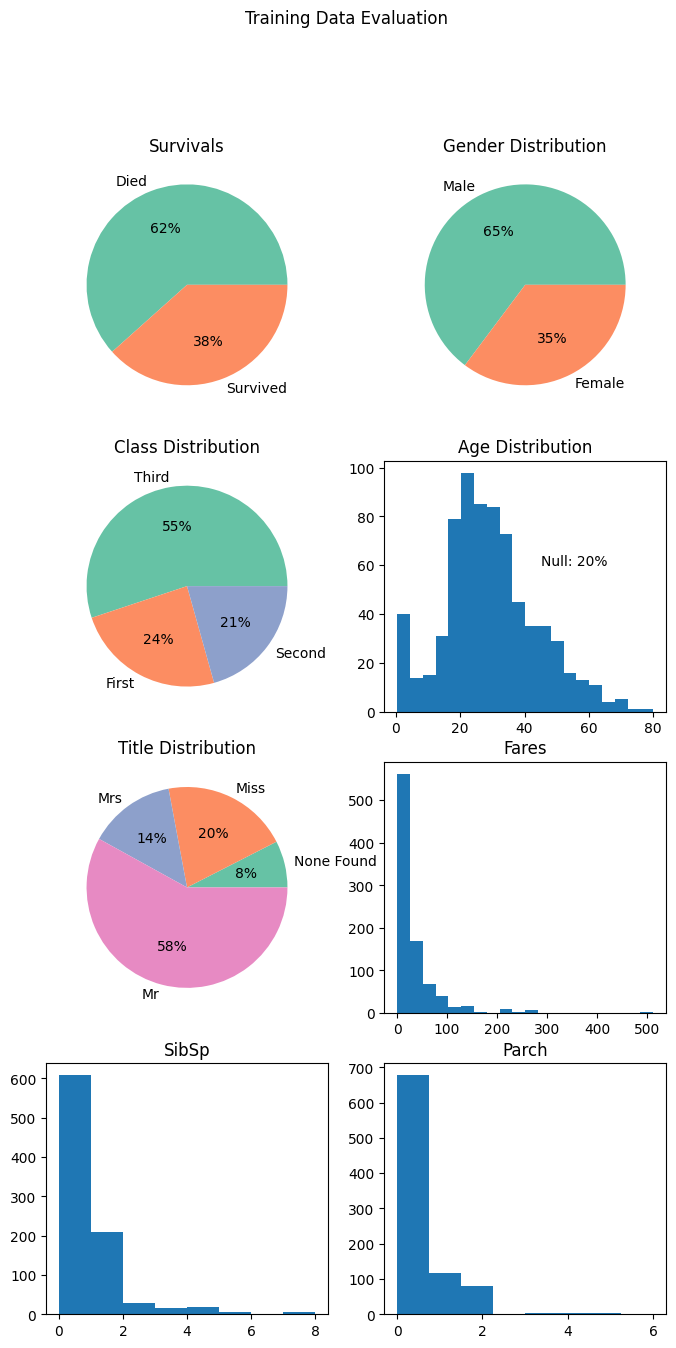

In [8]:

print(f"Training dataset shape: {RawTrainData.shape}")
print(f"Submission dataset shape: {RawSubmissionData.shape}")
print(RawTrainData.describe().round(2))

colors = sns.color_palette('Set2')

fig, axs = plt.subplots(4, 2, figsize=(8, 15))
fig.suptitle("Training Data Evaluation")

axs[0, 0].pie(x=RawTrainData['Survived'].value_counts(),labels=["Died", "Survived"], colors=colors[0:2], autopct="%1.0f%%")
axs[0, 0].set_title("Survivals")

axs[0, 1].pie(x=RawTrainData['Sex'].value_counts(),labels=["Male", "Female"], colors=colors[0:2], autopct="%1.0f%%")
axs[0, 1].set_title("Gender Distribution")

NullAgesAmount = len(RawTrainData[RawTrainData['Age'].isnull()])
axs[1, 1].hist(x=RawTrainData['Age'], bins=20)
axs[1, 1].set_title("Age Distribution")
axs[1, 1].text(45, 60, f"Null: {(NullAgesAmount / TOTAL_PASSENGERS_T)*100:2.0f}%")

axs[1, 0].pie(x=RawTrainData['Pclass'].value_counts(), labels=["Third", "First", "Second"], colors=colors[0:3], autopct="%1.0f%%")
axs[1, 0].set_title("Class Distribution")

TitleAmounts = [0, 0, 0, 0]
for p in RawTrainData['Name'].values:
    TitleAmounts[DetermineTitle(p)] += 1
TitleLabels = ["None Found", "Miss", "Mrs", "Mr"]

axs[2, 0].pie(TitleAmounts, labels=TitleLabels, colors=colors[0:4], autopct="%1.0f%%")
axs[2, 0].set_title("Title Distribution")

axs[2, 1].hist(x=RawTrainData['Fare'], bins=20)
axs[2, 1].set_title("Fares")

axs[3, 0].hist(x=RawTrainData['SibSp'], bins=8)
axs[3, 0].set_title("SibSp")

axs[3, 1].hist(x=RawTrainData['Parch'], bins=8)
axs[3, 1].set_title("Parch")

In [9]:
#Fetching all submission data
ALL_SUBMISSION_DATA = []
Passengers = []
for i in range(TOTAL_PASSENGERS_S):
    temp = []
    for a in RawSubmissionData:
        temp.append(RawSubmissionData[a].values[i])
    Passengers.append([str(a) for a in temp]) #Convert all to strings

ALL_SUBMISSION_DATA = np.array(ParsePassengerData(p) for p in Passengers)

#Fetching and sorting all training data
Passengers = []
for i in range(TOTAL_PASSENGERS_T):
    temp = []
    for a in RawTrainData:
        temp.append(RawTrainData[a].values[i])
    Passengers.append([str(a) for a in temp]) #Convert all to strings

ALL_TRAINING_DATA = [ParsePassengerData(p) for p in Passengers]
SixtyPer, TwentyPer = int(TOTAL_PASSENGERS_T * 0.6), int(TOTAL_PASSENGERS_T * 0.2)
Data_Train = np.array(ALL_TRAINING_DATA[:SixtyPer])
Data_Valid = np.array(ALL_TRAINING_DATA[SixtyPer:SixtyPer+TwentyPer])
Data_Test = np.array(ALL_TRAINING_DATA[SixtyPer+TwentyPer:])

In [10]:
def SeperateData(Data) -> list:
    id = []
    y = []
    x = []

    for p in Data:
        id.append(p[0])
        y.append(p[1])
        x.append(p[2:])
    
    return np.array(id), np.array(y), np.array(x)

def TrainModel(paramters: list, x_train: list, y_train: list, epochs: int = 100):
    print(type(x_train[0:2]))
    print(x_train[0:2])
    print(type(y_train[0:2]))
    print(y_train[0:2])
    
    # Setting up the Model
    Layers = []
    for param in paramters:
        Layers.append(tf.keras.layers.Dense(units=param[1], activation=param[0]))
    Layers.append(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    print(Layers)

    model = tf.keras.models.Sequential(Layers)

    print(type(x_train))
    print(x_train)

    predictions = model(x_train).numpy()
    predictions
    tf.nn.softmax(predictions).numpy()
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    loss_fn(y_train, predictions).numpy()
    optimizer = tf.keras.optimizers.legacy.Adam()
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    History = model.fit(x_train, y_train, epochs=epochs)
    return model

# Organize training data
id_train, x_train, y_train = SeperateData(Data_Train)

# Organize validation data
attributesValid = SeperateData(Data_Valid)
x_valid = [a[2] for a in attributesValid]
y_valid = [a[1] for a in attributesValid]

# Extract Trials
trials = []
with open(TRIALS_FILE, newline='') as trial_file:
    reader = csv.reader(trial_file, delimiter=',')
    for i, row in enumerate(reader):
        if i % 2 == 0:
            layer = [a for a in row[1:] if a != '']
        else:
            nodes = [int(a) for a in row[1:] if a != '']
            trials.append([(layer[a], nodes[a]) for a in range(len(layer))])
# Run all trials
BestModels = []
for trial in trials:
    temp_model = TrainModel(paramters=trial, x_train=x_train, y_train=y_train, epochs=1000)
    temp_model.evaluate(x_valid, y_valid, verbose=2)
    BestModels.append(temp_model)


<class 'numpy.ndarray'>
[0. 1.]
<class 'numpy.ndarray'>
[[ 1.      3.      3.      0.      0.      0.      1.      0.      1.
   7.25    0.      3.      0.    ]
 [ 0.      1.      2.      0.      0.      0.      1.      0.      1.
  71.2833  4.      1.      0.    ]]
[<keras.src.layers.core.dense.Dense object at 0x17adf26e0>, <keras.src.layers.core.dense.Dense object at 0x17cb1ff10>, <keras.src.layers.core.dense.Dense object at 0x17caa38b0>]


ValueError: Exception encountered when calling layer 'sequential' (type Sequential).

Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (534,)

Call arguments received by layer 'sequential' (type Sequential):
  • inputs=tf.Tensor(shape=(534,), dtype=float64)
  • training=None
  • mask=None